In this notebook we will be doing some further processing on the prefiltered data for the Victim From Predators disclosure (VFP) stage. It is important to note that only suspicious conversations (conversations that contain predator(s)) are fed into the VFP.

There are a few decisions to be made:
* We have to decide the type of document we feed into the VFP. A document contains messages written by a unique author ideantified by a id.
    - We could feed only one document per author. This means that we will be concantenating all messages from a unique author possible from multiple conversations if that author partook in multiple conversations in the dataset. The benefit of this approach is that we could possibly get a better picture of predators if we combine all messages in all conversations together.
    - We could feed one document per author per conversation. This means if an author partook in multiple conversations we will have multiple documents for that author. The benefit of this is this would better reflect the type of data in real-world.

We will use the second option for now.

In [1]:
import xml.etree.ElementTree as ET
import csv


def get_susp_conv_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_predators_dict(file): 
    all_predators = {}
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            all_predators[row[0]] = 1
    return all_predators
            

def get_features_labels(root, labels_dict, all_predators):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        # only get suspicious conversations
        if labels_dict[conversation.get('id')] == '0':
            continue
        author_conv_dict = {}
        for message in conversation:
            author = message.find('author').text
            text = message.find('text').text
            if text is not None:
                if author not in author_conv_dict:
                    author_conv_dict[author] = text
                else:
                    author_conv_dict[author] += " " + text 
        for author, conv in author_conv_dict.items():
            corpus.append(conv)
            if author in all_predators:
                labels.append(1)
            else:
                labels.append(-1)
    return corpus, labels

In [2]:
train_data_path = '../../data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = '../../data/svm_test_data/'
test_data_src = '../../data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

pred_train_file_path = '../../data/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt'
pred_test_file_path = '../../data/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem1.txt'
train_corpus, train_labels = get_features_labels(train_root, get_susp_conv_dict(train_data_path), get_predators_dict(pred_train_file_path))
test_corpus, test_labels = get_features_labels(test_root, get_susp_conv_dict(test_data_path), get_predators_dict(pred_test_file_path))

TODO: Save the model once trained to a pickle file!!!

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
# from sklearn.model_selection import train_test_split
import numpy as np

# print(train_corpus[:5])

vectorizer = TfidfVectorizer(ngram_range=(1,2))
# vectorizer = TfidfVectorizer(analyzer='word')
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))
print("Training label shape: {}".format(y_train.shape))
print("Testing label shape: {}".format(y_test.shape))

Training data shape: (1808, 120616)
Testing data shape: (5608, 120616)
Training data shape: (1808, 120616)
Testing data shape: (5608, 120616)
Training label shape: (1808,)
Testing label shape: (5608,)


linear, tol=0.01, Accuracy: 0.8915749682435224
linear, tol=0.001, Accuracy: 0.8926814710518665
linear, tol=0.0001, Accuracy: 0.892128984864021
linear, tol=1e-05, Accuracy: 0.892128984864021


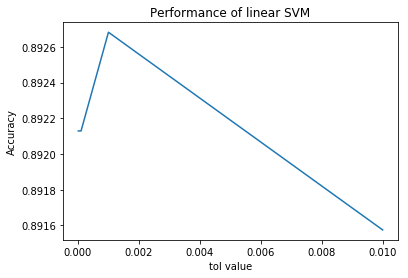

Best performing linear kernel SVM: C=0.001, Acc=0.8926814710518665


In [27]:
from sklearn import svm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import heapq
import operator
import numpy as np
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.svm import LinearSVC

num_fold = 5
k_fold = KFold(num_fold, True, 1)
kernel = 'linear'
acc = []
if kernel == 'linear':
#     for coef_c in np.arange(1, 30, 10):
    for tol in [1e-2, 1e-3, 1e-4, 1e-5]:
        acc_arr = np.zeros(num_fold)
        ind = 0
        for train_rows, val_rows in k_fold.split(X_train):
#             model = svm.SVC(kernel=kernel, C=1, gamma=gamma_val, random_state=0)
            model = LinearSVC(random_state=0, tol=tol, loss='squared_hinge', dual=True)
            model.fit(X_train[train_rows], y_train[train_rows])
            pred_y = model.predict(X_train[val_rows])
            acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
            ind += 1
        acc.append([tol, np.mean(acc_arr)])
#         print("{}, c={}, Accuracy: {}".format(kernel, coef_c, acc[len(acc)-1][1]))
        print("{}, tol={}, Accuracy: {}".format(kernel, tol, acc[len(acc)-1][1]))
    plt.plot([i[0] for i in acc], [i[1] for i in acc])
    plt.title("Performance of {} SVM".format(kernel))
    plt.xlabel("tol value")
    plt.ylabel("Accuracy")
    # plt.savefig('../output/As1_Qn4.2_' + kernel + '_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
    plt.show()
    best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
    print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))
elif kernel == 'poly':
    for degree in range(10):
        for coef_c in [1,10,100]:
            acc_arr = np.zeros(num_fold)
            ind = 0
            for train_rows, val_rows in k_fold.split(X_train):
                model = svm.SVC(kernel=kernel, C=coef_c, gamma='auto', random_state=0, degree=degree)
                model.fit(X_train[train_rows], y_train[train_rows])
                pred_y = model.predict(X_train[val_rows])
                acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
                ind += 1
            acc.append([degree, coef_c, np.mean(acc_arr)])
            print("{}, c={}, deg={}, Accuracy: {}".format(kernel, coef_c, degree, acc[len(acc)-1][2]))
    acc = np.array(acc)
    # print(acc)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.scatter3D(acc[:, 0], acc[:, 1], acc[:, 2])
    # fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.xlabel("Degree of polynomial SVM")
    plt.ylabel("C coefficient value")
    plt.title("Performance of Polynomial SVM")
    # plt.savefig('../output/As1_Qn4.2_' + kernel + '_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
    plt.show()
    best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
    print("Best performing poly kernel SVM: degree={}, C={}, Acc={}".format(best[0], best[1], best[2]))

In [32]:
# model = svm.SVC(kernel='linear', C=best[0], gamma='auto', random_state=0)
model = LinearSVC(random_state=0, tol=1e-5, loss='squared_hinge')
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

0.8643009985734664


In [35]:
import pickle
import datetime

# save the model to the models folder
filename = '../../models/VFP_SVM_' + "{:.2f}_".format(metrics.accuracy_score(y_test, pred_y)) + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.sav'
pickle.dump(model, open(filename, 'wb'))